<a href="https://colab.research.google.com/github/UdalovIA/ML/blob/main/ML_Cup_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
urllib.request.urlretrieve("https://storage.yandexcloud.net/audioml-contest22/dataset.tar.gz", "dataset.tar.gz")

KeyboardInterrupt: ignored

In [ ]:
#!python naive_baseline.py --features-dir /content/train_features --tracks-meta /content/train_meta.tsv --output /content/out/text.txt

In [2]:
from google.colab import drive
drive.mount('drive')
#!cp /content/train_meta.tsv "drive/My Drive/"

Mounted at drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/train_features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_features')

In [4]:
import shutil
shutil.copy("/content/drive/MyDrive/train_meta.tsv", "/content/")

'/content/train_meta.tsv'

In [5]:
!cp /content/train_meta.tsv "drive/My Drive/"

In [ ]:
import tarfile
import zipfile
zipfile = '/content/dataset.tar.gz'
if zipfile.endswith("tar.gz"):
    tar = tarfile.open(zipfile, "r:gz")
elif zipfile.endswith("tar"):
    tar = tarfile.open(zipfile, "r:")
tar.extractall()
tar.close()  

In [6]:
!pip install annoy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 20.4 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=397052 sha256=617e9b32715fb785d510564211974e6e0ba1e385a329c081b7769349d709ec72
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [7]:
# encoding=utf-8
import numpy as np
import pandas as pd
import os
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from tqdm import tqdm
import random
import annoy

In [8]:


# Data Loader 

def train_val_split(dataset, val_size = 0.2): # Сплит по artistid
    artist_ids = dataset['artistid'].unique()
    train_artist_ids, val_artist_ids = train_test_split(artist_ids, test_size = val_size)
    trainset = dataset[dataset['artistid'].isin(train_artist_ids)].copy()
    valset = dataset[dataset['artistid'].isin(val_artist_ids)].copy()
    return trainset, valset

class FeaturesLoader: 
    def __init__(self, features_dir_path, meta_info, device='cpu', crop_size = 60):
        self.features_dir_path = features_dir_path
        self.meta_info = meta_info
        self.trackid2path = meta_info.set_index('trackid')['archive_features_path'].to_dict()
        self.crop_size = crop_size
        self.device = device
        
    def _load_item(self, track_id):
        track_features_file_path = self.trackid2path[track_id]
        track_features = np.load(os.path.join(self.features_dir_path, track_features_file_path))
        padding = (track_features.shape[1] - self.crop_size) // 2
        return track_features[:, padding:padding+self.crop_size]
    
    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)

class TrainLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.meta_info.groupby('artistid').agg(list)
        
    def _generate_pairs(self, track_ids):
        np.random.shuffle(track_ids)
        pairs = [track_ids[i-2:i] for i in range(2, len(track_ids)+1, 2)]
        return pairs
        
    def _get_pair_ids(self):
        artist_track_ids = self.artist_track_ids.copy()
        artist_track_pairs = artist_track_ids['trackid'].map(self._generate_pairs)
        for pair_ids in artist_track_pairs.explode().dropna():
            yield pair_ids
            
    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(-1)
        batch_features = self.features_loader.load_batch(batch_ids)
        batch_features = batch_features.reshape(self.batch_size, 2, *self.features_size)
        return batch_features
        
    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

class TestLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        
    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.meta_info['trackid'].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids) 
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids) 





In [9]:
# Loss & Metrics

class NT_Xent(nn.Module):
    def __init__(self, temperature):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
 
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        with torch.no_grad():
            top1_negative_samples, _ = negative_samples.topk(1)
            avg_rank = logits.argsort(descending=True).argmin(dim=1).float().mean().cpu().numpy()

        return loss, avg_rank

def get_ranked_list(embeds, top_size, annoy_num_trees = 32):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in embeds.items():
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), 'angular')
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees)
    ranked_list = dict()
    for track_id in embeds.keys():
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size+1)[1:] # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list

def position_discounter(position):
    return 1.0 / np.log2(position+1)   

def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg

def compute_dcg(query_trackid, ranked_list, track2artist_map, top_size):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

def eval_submission(submission, gt_meta_info, top_size = 100):
    track2artist_map = gt_meta_info.set_index('trackid')['artistid'].to_dict()
    artist2tracks_map = gt_meta_info.groupby('artistid').agg(list)['trackid'].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count-1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map, top_size=top_size)
        try:
            ndcg_list.append(dcg/ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


In [10]:
def train(module, train_loader, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    losses = []
    metric1 = []
    metric2 = []
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            module.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            h_i, h_j, z_i, z_j = module(x_i, x_j)
            loss, avg_rank = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print("avg_rank: {}".format(avg_rank))
            print()
            losses.append(loss.item())
        
        with torch.no_grad():
            model_encoder = module.encoder
            embeds_encoder = inference(model_encoder, val_loader)
            ranked_list_encoder = get_ranked_list(embeds_encoder, top_size)
            val_ndcg_encoder = eval_submission(ranked_list_encoder, valset_meta)
            
            model_projector = nn.Sequential(module.encoder, module.projector)
            embeds_projector = inference(model_projector, val_loader)
            ranked_list_projector = get_ranked_list(embeds_projector, top_size)
            val_ndcg_projector = eval_submission(ranked_list_projector, valset_meta)
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)
            metric1.append(val_ndcg_encoder)
            metric2.append(val_ndcg_projector)
    return losses, metric1, metric2
def save_submission(submission, submission_path):
    with open(submission_path, 'w') as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result))))

In [29]:
# Train & Inference functions

class BasicNet(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.output_features_size = output_features_size
        self.kernel = 3
        self.conv_1 = nn.Conv1d(512, output_features_size, kernel_size=self.kernel, padding=1)
        self.conv_2 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(output_features_size, output_features_size//2, kernel_size=self.kernel, padding=1)
        self.conv_4 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)
        self.mp_2 = nn.MaxPool1d(2, 2)
        self.conv_5 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)
        self.conv_6 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)

        self.mp_3 = nn.MaxPool1d(2, 2)
        self.conv_7 = nn.Conv1d(output_features_size//4, output_features_size//8, kernel_size=self.kernel, padding=1)
        self.conv_8 = nn.Conv1d(output_features_size//8, output_features_size//8, kernel_size=self.kernel, padding=1)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = self.mp_2(x)
        x = F.relu(self.conv_5(x))
        x = (self.conv_6(x)).mean(axis = 2)
        '''  x = self.mp_3(x)
        x = F.relu(self.conv_7(x))
        x = F.relu(self.conv_8(x))'''
        return x

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size // 2
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )
        
    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)#.view(-1, 64*15)
        h_j = self.encoder(x_j)#.view(-1, 64*15)
        #print(x_i.shape)

        print('h_i.shape: ', h_i.shape)
        #print(h_j.shape)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        #z_i = self.projector(h_i.view(-1, 64*15))
        #z_j = self.projector(h_j.view(-1, 64*15))
        return h_i, h_j, z_i, z_j
#(32768x15 and 64x64)
def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)#.view(-1, 64*15)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds
def inference1(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model[1](model[0](tracks_features).view(-1, 64*15))
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds

In [30]:

#parser = ArgumentParser(description='Simple naive baseline')
#parser.add_argument('--base-dir', dest='base_dir', action='store', required=True)
#args = parser.parse_args()

base_dir = '/content'
    # Seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

TRAINSET_DIRNAME = 'train_features'
TESTSET_DIRNAME = 'test_features'
TRAINSET_META_FILENAME = 'train_meta.tsv'
TESTSET_META_FILENAME = 'test_meta.tsv'
SUBMISSION_FILENAME = 'submission.txt'
MODEL_FILENAME = 'model.pt'
CHECKPOINT_FILENAME = 'best.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 512
N_CHANNELS = 512
PROJECTION_DIM = 128
NUM_EPOCHS = 20
LR = 1e-4
TEMPERATURE = 0.1

TRAINSET_PATH = os.path.join(base_dir, TRAINSET_DIRNAME)
TESTSET_PATH = os.path.join(base_dir, TESTSET_DIRNAME)
TRAINSET_META_PATH = os.path.join(base_dir, TRAINSET_META_FILENAME)
TESTSET_META_PATH = os.path.join(base_dir, TESTSET_META_FILENAME)
SUBMISSION_PATH = os.path.join(base_dir, SUBMISSION_FILENAME)
MODEL_PATH = os.path.join(base_dir, MODEL_FILENAME)
CHECKPOINT_PATH = os.path.join(base_dir, CHECKPOINT_FILENAME)

In [31]:

sim_clr = SimCLR(
    encoder = BasicNet(N_CHANNELS),
    projection_dim = PROJECTION_DIM
).to(device)
'''
sim_clr = SimCLR(
    encoder = autoen.encoder,
    projection_dim = PROJECTION_DIM
).to(device)'''
train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep='\t')
#test_meta_info = pd.read_csv(TESTSET_META_PATH, sep='\t')
train_meta_info, validation_meta_info = train_val_split(train_meta_info, val_size=0.2)

print("Loaded data")
print("Train set size: {}".format(len(train_meta_info)))
print("Validation set size: {}".format(len(validation_meta_info)))
#print("Test set size: {}".format(len(test_meta_info)))
print()

print("Train")
l,m1,m2 = train(
        module = sim_clr,
        train_loader = TrainLoader(FeaturesLoader(TRAINSET_PATH, train_meta_info, device), batch_size = BATCH_SIZE),
        val_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
        valset_meta = validation_meta_info,
        optimizer = torch.optim.Adam(sim_clr.parameters(), lr = LR),
        criterion = NT_Xent(temperature = TEMPERATURE),
        num_epochs = NUM_EPOCHS,
        checkpoint_path = CHECKPOINT_PATH
)

print("Submission")
#test_loader = TestLoader(FeaturesLoader(TESTSET_PATH, test_meta_info, device), batch_size = BATCH_SIZE)
#model = sim_clr.encoder
#embeds = inference(model, test_loader)
#submission = get_ranked_list(embeds, 100)
#save_submission(submission, SUBMISSION_PATH)
#torch.save(sim_clr.state_dict(), MODEL_PATH)

Loaded data
Train set size: 39917
Validation set size: 9949

Train


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


1it [00:00,  1.14it/s]

loss: 6.9263458251953125
avg_rank: 228.251953125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


2it [00:02,  1.15s/it]

loss: 6.903179168701172
avg_rank: 211.05078125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


3it [00:03,  1.32s/it]

loss: 6.833527088165283
avg_rank: 238.9345703125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


4it [00:05,  1.38s/it]

loss: 6.665369987487793
avg_rank: 235.99609375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


5it [00:06,  1.46s/it]

loss: 6.490097522735596
avg_rank: 223.974609375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


6it [00:07,  1.36s/it]

loss: 6.488837718963623
avg_rank: 213.39453125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


7it [00:09,  1.37s/it]

loss: 6.380151271820068
avg_rank: 194.880859375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


8it [00:10,  1.36s/it]

loss: 6.226036071777344
avg_rank: 178.642578125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


9it [00:12,  1.36s/it]

loss: 6.26423978805542
avg_rank: 204.1357421875

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


10it [00:13,  1.34s/it]

loss: 6.2856245040893555
avg_rank: 211.3154296875

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


11it [00:14,  1.29s/it]

loss: 6.112992286682129
avg_rank: 178.3115234375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


12it [00:15,  1.30s/it]

loss: 6.020935535430908
avg_rank: 165.900390625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


13it [00:17,  1.28s/it]

loss: 6.067806243896484
avg_rank: 173.166015625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


14it [00:18,  1.27s/it]

loss: 5.969217777252197
avg_rank: 159.6611328125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


15it [00:19,  1.26s/it]

loss: 6.084236145019531
avg_rank: 178.0126953125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


16it [00:20,  1.27s/it]

loss: 5.868274688720703
avg_rank: 143.4609375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


17it [00:22,  1.30s/it]

loss: 5.972853660583496
avg_rank: 160.416015625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


18it [00:23,  1.32s/it]

loss: 5.901675701141357
avg_rank: 146.994140625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


19it [00:26,  1.83s/it]

loss: 5.744039058685303
avg_rank: 137.19921875

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


20it [00:29,  2.20s/it]

loss: 5.869012355804443
avg_rank: 153.037109375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


21it [00:32,  2.45s/it]

loss: 5.797178745269775
avg_rank: 140.0439453125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


22it [00:35,  2.63s/it]

loss: 5.775158882141113
avg_rank: 145.158203125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


23it [00:38,  2.77s/it]

loss: 5.77504301071167
avg_rank: 133.40234375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


24it [00:42,  2.90s/it]

loss: 5.821510314941406
avg_rank: 144.5595703125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


25it [00:45,  2.92s/it]

loss: 5.6391191482543945
avg_rank: 119.017578125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


26it [00:48,  2.99s/it]

loss: 5.7517409324646
avg_rank: 135.65625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


27it [00:51,  3.02s/it]

loss: 5.52356481552124
avg_rank: 109.9765625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


28it [00:54,  3.05s/it]

loss: 5.632089138031006
avg_rank: 127.908203125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


29it [00:57,  3.05s/it]

loss: 5.564705848693848
avg_rank: 112.8095703125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


30it [01:00,  3.06s/it]

loss: 5.686263084411621
avg_rank: 130.2509765625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


31it [01:03,  3.06s/it]

loss: 5.694615840911865
avg_rank: 132.9853515625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


32it [01:06,  3.03s/it]

loss: 5.536523342132568
avg_rank: 115.4833984375

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


33it [01:09,  3.01s/it]

loss: 5.45603084564209
avg_rank: 103.7421875

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


34it [01:12,  3.00s/it]

loss: 5.441108703613281
avg_rank: 101.796875

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


35it [01:15,  3.00s/it]

loss: 5.368776321411133
avg_rank: 96.603515625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


36it [01:18,  3.07s/it]

loss: 5.574187755584717
avg_rank: 116.66015625

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


37it [01:21,  3.02s/it]

loss: 5.452696323394775
avg_rank: 110.9736328125

h_i.shape:  torch.Size([512, 256])
Epoch 1/20


38it [01:24,  2.23s/it]


loss: 5.52393102645874
avg_rank: 116.013671875



100%|██████████| 9949/9949 [00:01<00:00, 5553.14it/s]


Validation nDCG on epoch 0
Encoder - 0.17741076013494106
Projector - 0.17109454068135788


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


1it [00:02,  2.88s/it]

loss: 5.478720664978027
avg_rank: 113.2587890625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


2it [00:05,  2.79s/it]

loss: 5.501997947692871
avg_rank: 118.5888671875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


3it [00:08,  2.78s/it]

loss: 5.583050727844238
avg_rank: 116.3544921875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


4it [00:11,  2.77s/it]

loss: 5.376561164855957
avg_rank: 99.572265625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


5it [00:13,  2.74s/it]

loss: 5.290171146392822
avg_rank: 92.166015625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


6it [00:16,  2.75s/it]

loss: 5.329582691192627
avg_rank: 94.0849609375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


7it [00:19,  2.72s/it]

loss: 5.211596488952637
avg_rank: 85.095703125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


8it [00:21,  2.72s/it]

loss: 5.316194534301758
avg_rank: 100.44140625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


9it [00:24,  2.72s/it]

loss: 5.331210136413574
avg_rank: 101.158203125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


10it [00:27,  2.74s/it]

loss: 5.457351207733154
avg_rank: 115.5546875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


11it [00:30,  2.78s/it]

loss: 5.270167827606201
avg_rank: 98.3955078125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


12it [00:33,  2.78s/it]

loss: 5.366997241973877
avg_rank: 103.263671875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


13it [00:35,  2.79s/it]

loss: 5.327271461486816
avg_rank: 105.68359375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


14it [00:38,  2.85s/it]

loss: 5.288156986236572
avg_rank: 96.203125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


15it [00:41,  2.84s/it]

loss: 5.399505138397217
avg_rank: 108.6865234375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


16it [00:44,  2.82s/it]

loss: 5.32099723815918
avg_rank: 96.447265625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


17it [00:47,  2.79s/it]

loss: 5.358978748321533
avg_rank: 98.736328125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


18it [00:49,  2.74s/it]

loss: 5.21854305267334
avg_rank: 85.28515625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


19it [00:52,  2.71s/it]

loss: 5.2668633460998535
avg_rank: 97.69140625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


20it [00:55,  2.68s/it]

loss: 5.3162665367126465
avg_rank: 100.6875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


21it [00:57,  2.67s/it]

loss: 5.242697715759277
avg_rank: 92.0947265625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


22it [01:00,  2.67s/it]

loss: 5.261044025421143
avg_rank: 96.505859375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


23it [01:02,  2.63s/it]

loss: 5.213897228240967
avg_rank: 91.3505859375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


24it [01:05,  2.63s/it]

loss: 5.183867454528809
avg_rank: 88.9326171875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


25it [01:08,  2.62s/it]

loss: 5.140894412994385
avg_rank: 85.1416015625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


26it [01:10,  2.64s/it]

loss: 5.25808048248291
avg_rank: 94.828125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


27it [01:13,  2.66s/it]

loss: 5.019740104675293
avg_rank: 79.05859375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


28it [01:16,  2.68s/it]

loss: 5.171271800994873
avg_rank: 91.3779296875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


29it [01:18,  2.69s/it]

loss: 5.054427623748779
avg_rank: 77.001953125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


30it [01:21,  2.70s/it]

loss: 5.050121784210205
avg_rank: 80.41015625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20
loss: 5.291533470153809
avg_rank: 99.572265625

31it [01:24,  2.69s/it]



h_i.shape:  torch.Size([512, 256])
Epoch 2/20


32it [01:27,  2.72s/it]

loss: 5.137538433074951
avg_rank: 88.0380859375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


33it [01:29,  2.67s/it]

loss: 5.114305019378662
avg_rank: 80.6953125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


34it [01:32,  2.65s/it]

loss: 5.170990467071533
avg_rank: 83.3623046875

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


35it [01:34,  2.63s/it]

loss: 5.0064239501953125
avg_rank: 72.4052734375

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


36it [01:37,  2.63s/it]

loss: 5.206223964691162
avg_rank: 92.4814453125

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


37it [01:40,  2.60s/it]

loss: 5.132430553436279
avg_rank: 87.541015625

h_i.shape:  torch.Size([512, 256])
Epoch 2/20


38it [01:42,  2.70s/it]


loss: 5.332015037536621
avg_rank: 104.9814453125



100%|██████████| 9949/9949 [00:01<00:00, 5545.96it/s]


Validation nDCG on epoch 1
Encoder - 0.2160727450257437
Projector - 0.2140575400082251


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


1it [00:02,  2.59s/it]

loss: 5.211006164550781
avg_rank: 92.9775390625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


2it [00:05,  2.54s/it]

loss: 5.294893741607666
avg_rank: 105.642578125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


3it [00:07,  2.56s/it]

loss: 5.168030261993408
avg_rank: 87.67578125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


4it [00:10,  2.59s/it]

loss: 5.170302867889404
avg_rank: 86.53515625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


5it [00:12,  2.61s/it]

loss: 5.161333084106445
avg_rank: 85.2265625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


6it [00:15,  2.62s/it]

loss: 4.9850754737854
avg_rank: 77.8603515625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


7it [00:18,  2.60s/it]

loss: 5.03334903717041
avg_rank: 76.333984375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


8it [00:20,  2.62s/it]

loss: 5.035388469696045
avg_rank: 82.900390625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


9it [00:23,  2.64s/it]

loss: 5.103037357330322
avg_rank: 87.748046875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


10it [00:26,  2.65s/it]

loss: 5.354072093963623
avg_rank: 109.7646484375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


11it [00:28,  2.66s/it]

loss: 5.080285549163818
avg_rank: 85.0693359375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


12it [00:31,  2.64s/it]

loss: 5.099474906921387
avg_rank: 83.5263671875

h_i.shape:  torch.Size([512, 256])


13it [00:34,  2.70s/it]

Epoch 3/20
loss: 5.141129016876221
avg_rank: 89.263671875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


14it [00:37,  2.73s/it]

loss: 5.179091930389404
avg_rank: 94.0966796875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


15it [00:39,  2.71s/it]

loss: 5.132141590118408
avg_rank: 83.421875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


16it [00:42,  2.75s/it]

loss: 5.162614345550537
avg_rank: 87.076171875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


17it [00:45,  2.76s/it]

loss: 5.246970176696777
avg_rank: 96.740234375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


18it [00:47,  2.72s/it]

loss: 5.169454097747803
avg_rank: 83.87890625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


19it [00:50,  2.72s/it]

loss: 5.091482639312744
avg_rank: 84.060546875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


20it [00:53,  2.72s/it]

loss: 5.0295610427856445
avg_rank: 79.1220703125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


21it [00:56,  2.72s/it]

loss: 5.001594543457031
avg_rank: 79.7099609375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


22it [00:58,  2.73s/it]

loss: 5.00501823425293
avg_rank: 80.94921875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


23it [01:01,  2.71s/it]

loss: 5.033073902130127
avg_rank: 80.6083984375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


24it [01:04,  2.73s/it]

loss: 4.958900451660156
avg_rank: 78.0751953125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


25it [01:07,  2.75s/it]

loss: 4.912647724151611
avg_rank: 72.48046875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


26it [01:10,  2.78s/it]

loss: 5.130681037902832
avg_rank: 82.693359375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


27it [01:12,  2.78s/it]

loss: 4.843545436859131
avg_rank: 67.0283203125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


28it [01:15,  2.75s/it]

loss: 4.940985202789307
avg_rank: 77.1240234375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


29it [01:18,  2.75s/it]

loss: 4.940301895141602
avg_rank: 79.4072265625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


30it [01:21,  2.84s/it]

loss: 4.861083984375
avg_rank: 71.306640625

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


31it [01:23,  2.81s/it]

loss: 5.002673625946045
avg_rank: 78.0673828125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


32it [01:26,  2.79s/it]

loss: 5.086031436920166
avg_rank: 81.486328125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


33it [01:29,  2.78s/it]

loss: 4.922145843505859
avg_rank: 72.54296875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


34it [01:32,  2.80s/it]

loss: 5.0501389503479
avg_rank: 78.439453125

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


35it [01:35,  2.79s/it]

loss: 4.9226861000061035
avg_rank: 73.9921875

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


36it [01:37,  2.81s/it]

loss: 5.0735626220703125
avg_rank: 83.18359375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


37it [01:40,  2.80s/it]

loss: 4.948863506317139
avg_rank: 79.0380859375

h_i.shape:  torch.Size([512, 256])
Epoch 3/20


38it [01:43,  2.73s/it]


loss: 5.135903358459473
avg_rank: 88.958984375



100%|██████████| 9949/9949 [00:01<00:00, 5480.11it/s]


Validation nDCG on epoch 2
Encoder - 0.23318697558568302
Projector - 0.24036898751426602


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


1it [00:02,  2.86s/it]

loss: 4.973763465881348
avg_rank: 77.763671875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


2it [00:05,  2.82s/it]

loss: 5.173859596252441
avg_rank: 93.943359375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


3it [00:08,  2.81s/it]

loss: 5.096248149871826
avg_rank: 85.537109375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


4it [00:11,  2.81s/it]

loss: 5.027711391448975
avg_rank: 80.984375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


5it [00:14,  2.84s/it]

loss: 4.913154125213623
avg_rank: 67.3720703125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


6it [00:16,  2.82s/it]

loss: 4.924742698669434
avg_rank: 75.6650390625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


7it [00:19,  2.79s/it]

loss: 4.800495624542236
avg_rank: 63.958984375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


8it [00:22,  2.77s/it]

loss: 4.779325008392334
avg_rank: 65.953125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


9it [00:25,  2.75s/it]

loss: 5.030950546264648
avg_rank: 80.9951171875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


10it [00:27,  2.78s/it]

loss: 5.048051357269287
avg_rank: 87.2705078125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


11it [00:30,  2.81s/it]

loss: 4.92274808883667
avg_rank: 77.7626953125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


12it [00:33,  2.78s/it]

loss: 4.971267223358154
avg_rank: 78.421875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


13it [00:36,  2.76s/it]

loss: 5.006319522857666
avg_rank: 79.80078125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


14it [00:38,  2.75s/it]

loss: 4.878851890563965
avg_rank: 73.1474609375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


15it [00:41,  2.74s/it]

loss: 5.0381011962890625
avg_rank: 82.0283203125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


16it [00:44,  2.76s/it]

loss: 5.017392635345459
avg_rank: 81.8154296875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


17it [00:47,  2.77s/it]

loss: 5.093653202056885
avg_rank: 90.1123046875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


18it [00:50,  2.79s/it]

loss: 4.875880241394043
avg_rank: 65.9169921875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


19it [00:52,  2.80s/it]

loss: 4.996642112731934
avg_rank: 83.9599609375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


20it [00:55,  2.80s/it]

loss: 4.902229309082031
avg_rank: 75.0888671875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


21it [00:58,  2.81s/it]

loss: 4.929695129394531
avg_rank: 75.0634765625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


22it [01:01,  2.82s/it]

loss: 4.904128074645996
avg_rank: 71.916015625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


23it [01:04,  2.81s/it]

loss: 4.92542028427124
avg_rank: 75.3369140625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


24it [01:07,  2.82s/it]

loss: 4.818078994750977
avg_rank: 72.74609375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


25it [01:09,  2.83s/it]

loss: 4.822991371154785
avg_rank: 69.1728515625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


26it [01:12,  2.84s/it]

loss: 4.936182022094727
avg_rank: 72.5546875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


27it [01:15,  2.86s/it]

loss: 4.812423229217529
avg_rank: 68.380859375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


28it [01:18,  2.82s/it]

loss: 4.740608215332031
avg_rank: 68.751953125

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


29it [01:21,  2.77s/it]

loss: 4.7741546630859375
avg_rank: 68.228515625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


30it [01:23,  2.76s/it]

loss: 4.736473560333252
avg_rank: 68.84375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


31it [01:26,  2.73s/it]

loss: 4.839010715484619
avg_rank: 72.6962890625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


32it [01:29,  2.73s/it]

loss: 4.9763875007629395
avg_rank: 78.494140625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


33it [01:31,  2.70s/it]

loss: 4.873427391052246
avg_rank: 66.90234375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


34it [01:34,  2.70s/it]

loss: 4.804068088531494
avg_rank: 64.5341796875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


35it [01:37,  2.68s/it]

loss: 4.7731852531433105
avg_rank: 67.6484375

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


36it [01:39,  2.68s/it]

loss: 4.962672233581543
avg_rank: 77.3857421875

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


37it [01:42,  2.67s/it]

loss: 4.895492076873779
avg_rank: 72.4541015625

h_i.shape:  torch.Size([512, 256])
Epoch 4/20


38it [01:45,  2.77s/it]


loss: 5.05122709274292
avg_rank: 83.859375



100%|██████████| 9949/9949 [00:03<00:00, 2739.40it/s]


Validation nDCG on epoch 3
Encoder - 0.24591884456302268
Projector - 0.25422796994568597


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


1it [00:02,  2.63s/it]

loss: 4.768727779388428
avg_rank: 64.666015625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


2it [00:05,  2.57s/it]

loss: 4.981292247772217
avg_rank: 81.771484375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


3it [00:07,  2.58s/it]

loss: 4.9331841468811035
avg_rank: 77.28515625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


4it [00:10,  2.60s/it]

loss: 4.921116352081299
avg_rank: 75.478515625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


5it [00:13,  2.63s/it]

loss: 4.783786296844482
avg_rank: 65.748046875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


6it [00:15,  2.65s/it]

loss: 4.762323379516602
avg_rank: 66.818359375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


7it [00:18,  2.62s/it]

loss: 4.6836628913879395
avg_rank: 59.3935546875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


8it [00:20,  2.63s/it]

loss: 4.836190223693848
avg_rank: 67.8662109375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


9it [00:23,  2.70s/it]

loss: 4.841917514801025
avg_rank: 66.2080078125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


10it [00:26,  2.70s/it]

loss: 4.998437404632568
avg_rank: 82.5068359375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


11it [00:29,  2.69s/it]

loss: 4.836550235748291
avg_rank: 71.5

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


12it [00:31,  2.67s/it]

loss: 4.80275821685791
avg_rank: 68.7939453125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


13it [00:34,  2.67s/it]

loss: 4.948843955993652
avg_rank: 80.4130859375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


14it [00:37,  2.68s/it]

loss: 4.873626232147217
avg_rank: 72.826171875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


15it [00:39,  2.67s/it]

loss: 4.970193386077881
avg_rank: 79.6845703125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


16it [00:42,  2.67s/it]

loss: 4.855099678039551
avg_rank: 68.541015625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


17it [00:45,  2.71s/it]

loss: 4.985707759857178
avg_rank: 84.2001953125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


18it [00:47,  2.69s/it]

loss: 4.792551040649414
avg_rank: 62.8759765625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


19it [00:50,  2.69s/it]

loss: 4.851346969604492
avg_rank: 72.849609375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


20it [00:53,  2.72s/it]

loss: 4.920581340789795
avg_rank: 77.8564453125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


21it [00:56,  2.73s/it]

loss: 4.913977146148682
avg_rank: 73.396484375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


22it [00:58,  2.74s/it]

loss: 4.78264856338501
avg_rank: 63.908203125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


23it [01:01,  2.74s/it]

loss: 4.7888970375061035
avg_rank: 66.3603515625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


24it [01:04,  2.75s/it]

loss: 4.75270414352417
avg_rank: 65.9130859375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


25it [01:07,  2.78s/it]

loss: 4.801114082336426
avg_rank: 71.57421875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


26it [01:10,  2.87s/it]

loss: 4.887118339538574
avg_rank: 75.5048828125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


27it [01:13,  2.84s/it]

loss: 4.643656253814697
avg_rank: 56.1416015625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


28it [01:15,  2.82s/it]

loss: 4.721080303192139
avg_rank: 68.060546875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


29it [01:18,  2.82s/it]

loss: 4.699777603149414
avg_rank: 64.7841796875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


30it [01:21,  2.81s/it]

loss: 4.640271186828613
avg_rank: 59.8291015625

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


31it [01:24,  2.80s/it]

loss: 4.778544902801514
avg_rank: 70.3974609375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


32it [01:27,  2.79s/it]

loss: 4.870086669921875
avg_rank: 74.08984375

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


33it [01:29,  2.77s/it]

loss: 4.786061763763428
avg_rank: 65.6982421875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


34it [01:32,  2.78s/it]

loss: 4.75649356842041
avg_rank: 62.76171875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


35it [01:35,  2.76s/it]

loss: 4.634622097015381
avg_rank: 60.8720703125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


36it [01:38,  2.76s/it]

loss: 4.903985977172852
avg_rank: 78.203125

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


37it [01:40,  2.76s/it]

loss: 4.84096097946167
avg_rank: 74.2216796875

h_i.shape:  torch.Size([512, 256])
Epoch 5/20


38it [01:43,  2.73s/it]


loss: 4.945206642150879
avg_rank: 71.576171875



100%|██████████| 9949/9949 [00:01<00:00, 5569.30it/s]


Validation nDCG on epoch 4
Encoder - 0.25749647646454904
Projector - 0.2676593056157368


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


1it [00:02,  2.81s/it]

loss: 4.831192493438721
avg_rank: 68.0107421875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


2it [00:05,  2.68s/it]

loss: 4.895689010620117
avg_rank: 81.306640625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


3it [00:08,  2.68s/it]

loss: 4.948112964630127
avg_rank: 77.0322265625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


4it [00:10,  2.71s/it]

loss: 4.884618759155273
avg_rank: 74.0107421875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


5it [00:13,  2.72s/it]

loss: 4.685678958892822
avg_rank: 63.3974609375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


6it [00:16,  2.79s/it]

loss: 4.7653584480285645
avg_rank: 67.92578125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


7it [00:19,  2.78s/it]

loss: 4.590887546539307
avg_rank: 55.4892578125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


8it [00:22,  2.79s/it]

loss: 4.632050514221191
avg_rank: 59.06640625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


9it [00:24,  2.76s/it]

loss: 4.861008644104004
avg_rank: 73.1552734375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


10it [00:27,  2.76s/it]

loss: 5.017324447631836
avg_rank: 83.1083984375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


11it [00:30,  2.75s/it]

loss: 4.6474080085754395
avg_rank: 61.6259765625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


12it [00:32,  2.74s/it]

loss: 4.865360260009766
avg_rank: 75.6513671875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


13it [00:35,  2.72s/it]

loss: 4.8528313636779785
avg_rank: 79.4033203125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


14it [00:38,  2.72s/it]

loss: 4.738421440124512
avg_rank: 63.2177734375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


15it [00:41,  2.72s/it]

loss: 4.86497163772583
avg_rank: 74.8173828125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


16it [00:43,  2.72s/it]

loss: 4.800624370574951
avg_rank: 68.40234375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


17it [00:46,  2.73s/it]

loss: 5.013887405395508
avg_rank: 82.97265625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


18it [00:49,  2.75s/it]

loss: 4.716958045959473
avg_rank: 62.1552734375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


19it [00:52,  2.82s/it]

loss: 4.6829423904418945
avg_rank: 61.01953125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


20it [00:54,  2.77s/it]

loss: 4.726655960083008
avg_rank: 68.4287109375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


21it [00:57,  2.71s/it]

loss: 4.807873725891113
avg_rank: 66.43359375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


22it [01:00,  2.72s/it]

loss: 4.716423988342285
avg_rank: 60.576171875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


23it [01:03,  2.75s/it]

loss: 4.731080532073975
avg_rank: 65.3818359375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


24it [01:05,  2.77s/it]

loss: 4.590247631072998
avg_rank: 62.3642578125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


25it [01:08,  2.75s/it]

loss: 4.681338310241699
avg_rank: 68.302734375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


26it [01:11,  2.75s/it]

loss: 4.754901885986328
avg_rank: 68.076171875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


27it [01:14,  2.71s/it]

loss: 4.61022424697876
avg_rank: 55.44140625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


28it [01:16,  2.67s/it]

loss: 4.618077278137207
avg_rank: 64.7421875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


29it [01:19,  2.65s/it]

loss: 4.707335948944092
avg_rank: 63.1318359375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


30it [01:21,  2.63s/it]

loss: 4.596498489379883
avg_rank: 60.5009765625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


31it [01:24,  2.59s/it]

loss: 4.644674301147461
avg_rank: 61.123046875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


32it [01:26,  2.61s/it]

loss: 4.63457727432251
avg_rank: 56.4599609375

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


33it [01:29,  2.61s/it]

loss: 4.6285247802734375
avg_rank: 57.2197265625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


34it [01:32,  2.63s/it]

loss: 4.631767749786377
avg_rank: 57.7919921875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


35it [01:34,  2.63s/it]

loss: 4.483454704284668
avg_rank: 53.0751953125

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


36it [01:37,  2.65s/it]

loss: 4.802603721618652
avg_rank: 72.9794921875

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


37it [01:40,  2.63s/it]

loss: 4.604766368865967
avg_rank: 59.4462890625

h_i.shape:  torch.Size([512, 256])
Epoch 6/20


38it [01:42,  2.70s/it]


loss: 4.782779216766357
avg_rank: 66.0048828125



100%|██████████| 9949/9949 [00:01<00:00, 5395.89it/s]


Validation nDCG on epoch 5
Encoder - 0.26452645193320734
Projector - 0.28152653673017713


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


1it [00:02,  2.71s/it]

loss: 4.637939929962158
avg_rank: 59.275390625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


2it [00:05,  2.60s/it]

loss: 4.886902809143066
avg_rank: 78.4794921875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


3it [00:07,  2.57s/it]

loss: 4.773802280426025
avg_rank: 69.44921875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


4it [00:10,  2.58s/it]

loss: 4.713290214538574
avg_rank: 62.4150390625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


5it [00:13,  2.63s/it]

loss: 4.547182083129883
avg_rank: 50.234375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


6it [00:15,  2.70s/it]

loss: 4.668346405029297
avg_rank: 60.892578125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


7it [00:18,  2.68s/it]

loss: 4.55114221572876
avg_rank: 55.0830078125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


8it [00:21,  2.68s/it]

loss: 4.629229545593262
avg_rank: 59.03125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


9it [00:23,  2.68s/it]

loss: 4.717534065246582
avg_rank: 66.880859375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


10it [00:26,  2.70s/it]

loss: 4.834478378295898
avg_rank: 74.6728515625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


11it [00:29,  2.68s/it]

loss: 4.596750259399414
avg_rank: 60.986328125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


12it [00:31,  2.67s/it]

loss: 4.677430152893066
avg_rank: 64.58984375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


13it [00:34,  2.65s/it]

loss: 4.742901802062988
avg_rank: 67.9228515625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


14it [00:37,  2.65s/it]

loss: 4.759549617767334
avg_rank: 65.06640625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


15it [00:39,  2.64s/it]

loss: 4.721566677093506
avg_rank: 66.693359375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


16it [00:42,  2.64s/it]

loss: 4.80946683883667
avg_rank: 70.642578125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


17it [00:45,  2.66s/it]

loss: 4.984455108642578
avg_rank: 82.14453125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


18it [00:47,  2.64s/it]

loss: 4.620924949645996
avg_rank: 53.4423828125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


19it [00:50,  2.66s/it]

loss: 4.685205459594727
avg_rank: 65.095703125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


20it [00:53,  2.69s/it]

loss: 4.621496200561523
avg_rank: 59.5625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


21it [00:56,  2.75s/it]

loss: 4.696955680847168
avg_rank: 61.138671875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


22it [00:59,  2.84s/it]

loss: 4.59011173248291
avg_rank: 58.861328125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


23it [01:02,  2.87s/it]

loss: 4.7201433181762695
avg_rank: 64.515625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


24it [01:05,  2.88s/it]

loss: 4.629546165466309
avg_rank: 63.1806640625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


25it [01:07,  2.86s/it]

loss: 4.612016677856445
avg_rank: 55.201171875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


26it [01:10,  2.88s/it]

loss: 4.709835052490234
avg_rank: 64.3037109375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


27it [01:13,  2.83s/it]

loss: 4.556572914123535
avg_rank: 55.462890625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


28it [01:16,  2.80s/it]

loss: 4.490535259246826
avg_rank: 57.826171875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


29it [01:19,  2.81s/it]

loss: 4.5924506187438965
avg_rank: 63.275390625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


30it [01:21,  2.81s/it]

loss: 4.533586025238037
avg_rank: 56.80078125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


31it [01:24,  2.79s/it]

loss: 4.597079277038574
avg_rank: 59.5693359375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


32it [01:27,  2.80s/it]

loss: 4.645355701446533
avg_rank: 62.33203125

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


33it [01:30,  2.77s/it]

loss: 4.649918556213379
avg_rank: 60.3427734375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


34it [01:32,  2.78s/it]

loss: 4.566908836364746
avg_rank: 53.0478515625

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


35it [01:35,  2.78s/it]

loss: 4.471042633056641
avg_rank: 56.0732421875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


36it [01:38,  2.79s/it]

loss: 4.658896446228027
avg_rank: 66.6552734375

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


37it [01:41,  2.79s/it]

loss: 4.557744026184082
avg_rank: 57.529296875

h_i.shape:  torch.Size([512, 256])
Epoch 7/20


38it [01:44,  2.74s/it]


loss: 4.778086185455322
avg_rank: 67.1533203125



100%|██████████| 9949/9949 [00:01<00:00, 5130.19it/s]


Validation nDCG on epoch 6
Encoder - 0.2743775606331548
Projector - 0.2924048152660072


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


1it [00:02,  2.77s/it]

loss: 4.585975170135498
avg_rank: 58.6044921875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


2it [00:05,  2.69s/it]

loss: 4.833623886108398
avg_rank: 77.892578125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


3it [00:08,  2.75s/it]

loss: 4.781599521636963
avg_rank: 67.14453125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


4it [00:11,  2.77s/it]

loss: 4.703304767608643
avg_rank: 65.8056640625

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


5it [00:13,  2.77s/it]

loss: 4.630473613739014
avg_rank: 54.5380859375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


6it [00:16,  2.76s/it]

loss: 4.636473178863525
avg_rank: 58.5009765625

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


7it [00:19,  2.76s/it]

loss: 4.5222063064575195
avg_rank: 54.16796875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


8it [00:22,  2.77s/it]

loss: 4.573315143585205
avg_rank: 60.923828125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


9it [00:24,  2.77s/it]

loss: 4.753661632537842
avg_rank: 69.8681640625

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


10it [00:27,  2.79s/it]

loss: 4.801357269287109
avg_rank: 72.5029296875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


11it [00:30,  2.79s/it]

loss: 4.594327926635742
avg_rank: 64.5771484375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


12it [00:33,  2.77s/it]

loss: 4.64363956451416
avg_rank: 60.0986328125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


13it [00:35,  2.73s/it]

loss: 4.668474197387695
avg_rank: 64.7958984375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


14it [00:38,  2.71s/it]

loss: 4.623939037322998
avg_rank: 59.4560546875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


15it [00:41,  2.68s/it]

loss: 4.834746360778809
avg_rank: 71.7890625

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


16it [00:43,  2.67s/it]

loss: 4.653343200683594
avg_rank: 63.6435546875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


17it [00:46,  2.67s/it]

loss: 4.913127899169922
avg_rank: 79.7294921875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


18it [00:49,  2.67s/it]

loss: 4.573333263397217
avg_rank: 54.5263671875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


19it [00:51,  2.72s/it]

loss: 4.635776519775391
avg_rank: 60.7568359375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


20it [00:54,  2.77s/it]

loss: 4.720759391784668
avg_rank: 68.630859375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


21it [00:57,  2.79s/it]

loss: 4.639673709869385
avg_rank: 59.08984375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


22it [01:00,  2.78s/it]

loss: 4.611738681793213
avg_rank: 58.3408203125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


23it [01:03,  2.80s/it]

loss: 4.621867656707764
avg_rank: 63.287109375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


24it [01:06,  2.81s/it]

loss: 4.478183269500732
avg_rank: 56.720703125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


25it [01:08,  2.79s/it]

loss: 4.58889627456665
avg_rank: 58.6142578125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


26it [01:11,  2.79s/it]

loss: 4.759913444519043
avg_rank: 70.587890625

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


27it [01:14,  2.75s/it]

loss: 4.549991607666016
avg_rank: 54.7470703125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


28it [01:16,  2.70s/it]

loss: 4.565689563751221
avg_rank: 57.2607421875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


29it [01:19,  2.66s/it]

loss: 4.56442403793335
avg_rank: 61.9833984375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


30it [01:22,  2.64s/it]

loss: 4.448354721069336
avg_rank: 54.513671875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


31it [01:24,  2.62s/it]

loss: 4.561222076416016
avg_rank: 59.0205078125

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


32it [01:27,  2.62s/it]

loss: 4.636632442474365
avg_rank: 63.46875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


33it [01:29,  2.62s/it]

loss: 4.5291666984558105
avg_rank: 57.787109375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


34it [01:32,  2.63s/it]

loss: 4.538742542266846
avg_rank: 50.7734375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


35it [01:35,  2.64s/it]

loss: 4.505039691925049
avg_rank: 57.9248046875

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


36it [01:37,  2.66s/it]

loss: 4.733572959899902
avg_rank: 66.1240234375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


37it [01:40,  2.70s/it]

loss: 4.729612350463867
avg_rank: 66.115234375

h_i.shape:  torch.Size([512, 256])
Epoch 8/20


38it [01:43,  2.72s/it]


loss: 4.674887657165527
avg_rank: 61.00390625



100%|██████████| 9949/9949 [00:01<00:00, 5472.53it/s]


Validation nDCG on epoch 7
Encoder - 0.2767833608614286
Projector - 0.2930720104713863


0it [00:00, ?it/s]

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


1it [00:02,  2.63s/it]

loss: 4.56646728515625
avg_rank: 55.865234375

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


2it [00:05,  2.64s/it]

loss: 4.733645915985107
avg_rank: 67.12109375

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


3it [00:07,  2.61s/it]

loss: 4.731209754943848
avg_rank: 69.6474609375

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


4it [00:10,  2.61s/it]

loss: 4.683890342712402
avg_rank: 63.142578125

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


5it [00:13,  2.61s/it]

loss: 4.512729644775391
avg_rank: 50.830078125

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


6it [00:15,  2.67s/it]

loss: 4.610784530639648
avg_rank: 60.337890625

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


7it [00:18,  2.63s/it]

loss: 4.379138469696045
avg_rank: 44.0625

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


8it [00:20,  2.61s/it]

loss: 4.516743183135986
avg_rank: 55.134765625

h_i.shape:  torch.Size([512, 256])
Epoch 9/20


9it [00:23,  2.63s/it]

loss: 4.564576625823975
avg_rank: 63.8759765625



9it [00:25,  2.82s/it]


KeyboardInterrupt: ignored

**Encoder**

In [ ]:
def train_ae(module, train_loader,optimizer, criterion, num_epochs): #, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    losses = []
    for epoch in range(num_epochs):
        for tracks_ids, tracks_features in train_loader:
            optimizer.zero_grad()
            module.train()
            reconstructed, _ = module(tracks_features)
            loss = criterion(reconstructed, tracks_features)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print()
            losses.append(loss.item())
        '''with torch.no_grad():
            module.eval()
            for X_batch in val_loader:
                X_batch = X_batch.view(-1, 3, 64, 64).float()
                reconstructed, _ = model(X_batch.to(device))
                loss = loss_fn(reconstructed.view(-1, 3, 64, 64), X_batch.to(device))
                val_losses_per_epoch.append(loss.item())
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)'''
    return losses

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.n_features = output_features_size

        self.encoder = nn.Sequential(
            nn.Conv1d(512, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features//2, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//2, self.n_features//2, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//2, self.n_features//4, kernel_size=3, padding=1),

            nn.Conv1d(self.n_features//4, self.n_features//4, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//4, self.n_features//8, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1)
        )
       
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(self.n_features//8, self.n_features//8, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//8, self.n_features//4,stride =2, kernel_size=3, padding=0),
           #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features//4, self.n_features//2, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//2, self.n_features, kernel_size=3, padding=1),
            #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features, self.n_features,stride = 2,kernel_size=2, padding=1),
            nn.ConvTranspose1d(self.n_features, self.n_features, kernel_size=3, padding=1)
        )

    def forward(self, x):
        print('x.shape ' , x.shape)
        latent = self.encoder(x) #.view(-1, 512)
        print('latent.shape ' ,latent.shape)
        #latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        print('reconstructed.shape ' ,reconstructed.shape)
        return reconstructed, latent


In [ ]:
autoen = Autoencoder(
    output_features_size = 512,
).to(device)

In [ ]:
losses = train_ae(module= autoen,
         train_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
         optimizer = torch.optim.Adam(autoen.parameters(), lr = LR),
         criterion = F.mse_loss,
         num_epochs = NUM_EPOCHS)

In [ ]:
with open("losses.txt", "w") as output:
    output.write(str(l))

In [ ]:
with open("met1.txt", "w") as output:
    output.write(str(m1))

In [ ]:
with open("met2.txt", "w") as output:
    output.write(str(m2))

In [ ]:
plt.plot(losses)

NameError: ignored

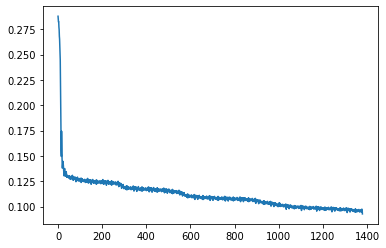

In [ ]:

plt.plot(losses)

In [ ]:
l1, m11, m21 = l, m1, m2

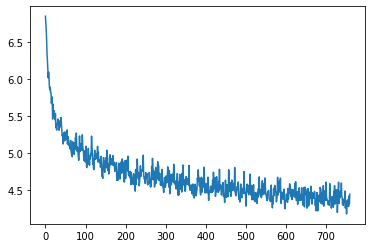

In [ ]:
import matplotlib.pyplot as plt

plt.plot(l)

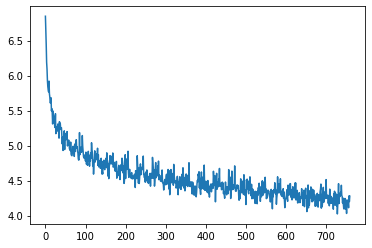

In [ ]:
plt.plot(l1)

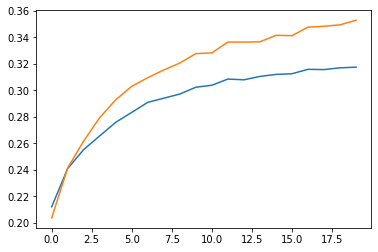

In [ ]:
plt.plot(m1)
plt.plot(m2)

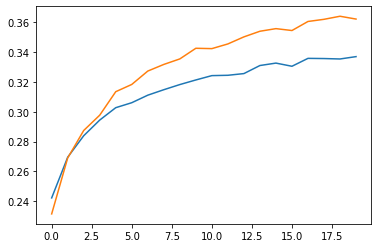

In [ ]:
plt.plot(m11)
plt.plot(m21)